In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import shutil
from tqdm import tqdm

# Dataset path
DATASET_DIR = '../input/structural-defects-network-concrete-crack-images'

# Step 1: Prepare dataset - collect cracked and non-cracked image paths
def collect_image_paths(root_dir):
    image_paths = []
    labels = []
    for structure in ['Decks', 'Pavements', 'Walls']:
        for label_name in ['Cracked', 'Non-cracked']:
            label = 1 if label_name == 'Cracked' else 0
            folder = os.path.join(root_dir, structure, label_name)
            for filename in os.listdir(folder):
                if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                    image_paths.append(os.path.join(folder, filename))
                    labels.append(label)
    return image_paths, labels

image_paths, labels = collect_image_paths(DATASET_DIR)

# Split into train and test (80-20)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Custom dataset class
class CrackDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Datasets and DataLoaders
train_dataset = CrackDataset(train_paths, train_labels, transform=transform_train)
test_dataset = CrackDataset(test_paths, test_labels, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Model definition (ResNet18 fine-tuned)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Step 3: Training loop with model saving
EPOCHS = 2
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f}")
    
    # Save model
    torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1}.pth")

# Step 4: Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

# Results
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-cracked', 'Cracked']))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 
Epoch 1/2: 100%|██████████| 1403/1403 [1:32:33<00:00,  3.96s/it]


Epoch [1/2] Loss: 0.2419


Epoch 2/2: 100%|██████████| 1403/1403 [1:29:12<00:00,  3.81s/it]


Epoch [2/2] Loss: 0.1985

Classification Report:
              precision    recall  f1-score   support

 Non-cracked       0.96      0.95      0.95      9522
     Cracked       0.74      0.75      0.75      1697

    accuracy                           0.92     11219
   macro avg       0.85      0.85      0.85     11219
weighted avg       0.92      0.92      0.92     11219

Confusion Matrix:
[[9082  440]
 [ 420 1277]]
Test Accuracy: 0.9233


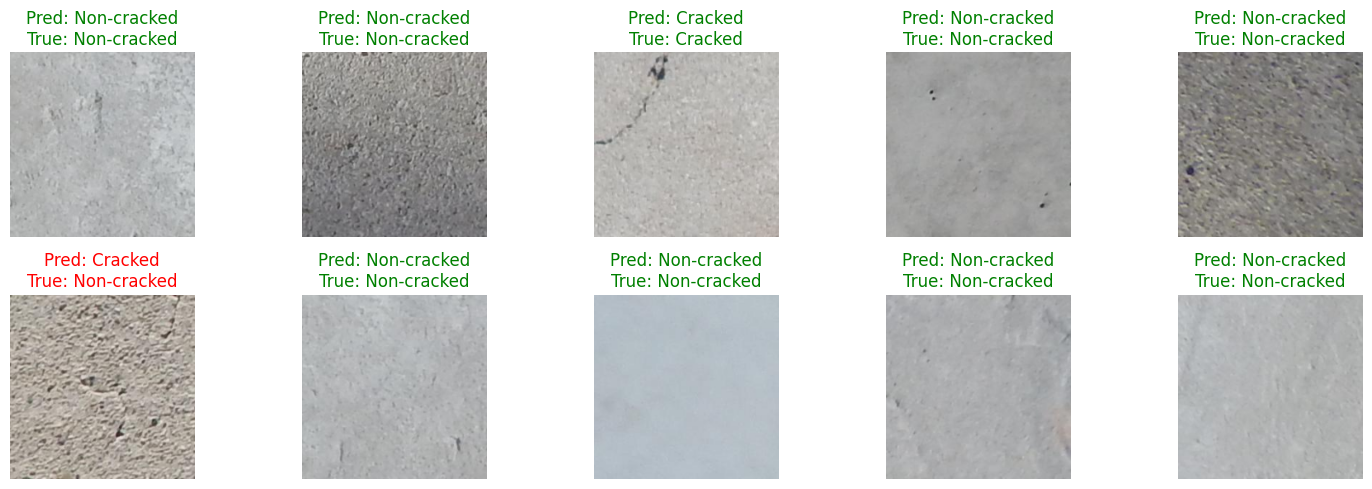

In [2]:
import random

# Map for class labels
class_names = ['Non-cracked', 'Cracked']

# Function to display predictions
def visualize_predictions(model, dataset, num_images=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        pred_label = pred.item()
        true_label = label

        plt.subplot(2, num_images//2, i+1)
        img_np = image.permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        plt.axis('off')
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", color=color)

    plt.tight_layout()
    plt.show()

# Show sample predictions
visualize_predictions(model, test_dataset, num_images=10)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


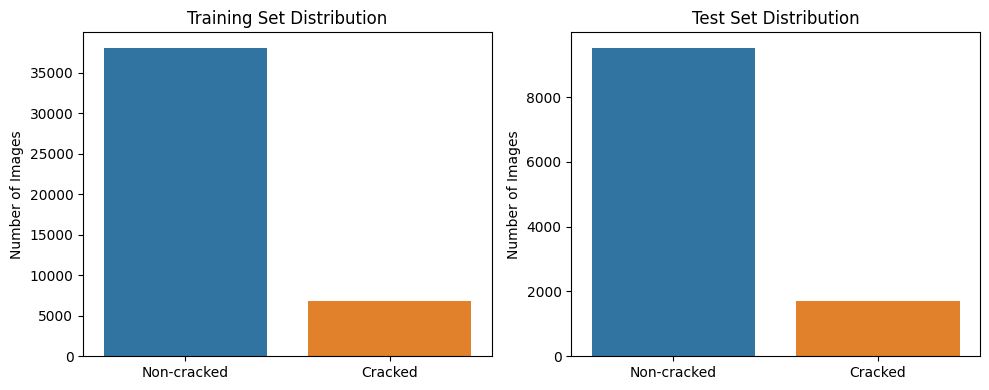

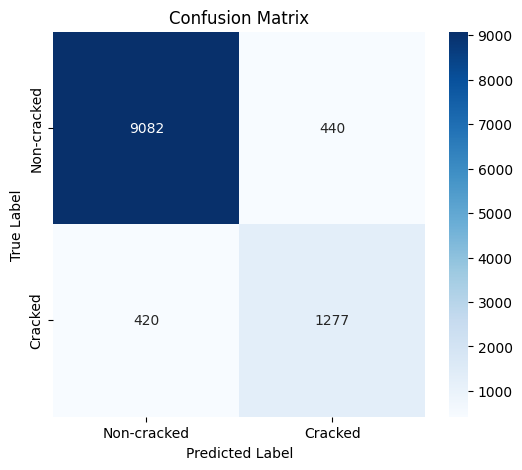

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


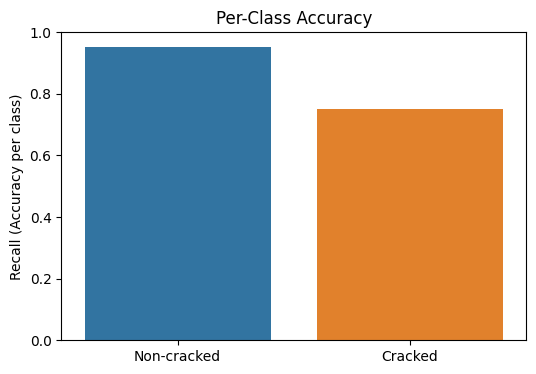

In [3]:
import seaborn as sns
from collections import Counter

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# === 1. Class Distribution in Train and Test Sets ===
train_counter = Counter(train_labels)
test_counter = Counter(test_labels)

plt.figure(figsize=(10, 4))

# Train distribution
plt.subplot(1, 2, 1)
sns.barplot(x=['Non-cracked', 'Cracked'], y=[train_counter[0], train_counter[1]])
plt.title("Training Set Distribution")
plt.ylabel("Number of Images")

# Test distribution
plt.subplot(1, 2, 2)
sns.barplot(x=['Non-cracked', 'Cracked'], y=[test_counter[0], test_counter[1]])
plt.title("Test Set Distribution")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()

# === 2. Confusion Matrix Heatmap ===
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-cracked', 'Cracked'],
            yticklabels=['Non-cracked', 'Cracked'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === 3. Per-Class Accuracy Bar Plot ===
cr = classification_report(all_labels, all_preds, output_dict=True)
per_class_acc = [cr['0']['recall'], cr['1']['recall']]

plt.figure(figsize=(6, 4))
sns.barplot(x=['Non-cracked', 'Cracked'], y=per_class_acc)
plt.ylim(0, 1)
plt.ylabel("Recall (Accuracy per class)")
plt.title("Per-Class Accuracy")
plt.show()


In [5]:
import shutil

# Zip the checkpoints directory
shutil.make_archive('crack_model_checkpoints', 'zip', 'checkpoints')


'/kaggle/working/crack_model_checkpoints.zip'